# Programming Assignment 2: Classification Task and Performance Evaluation (10 points)

### February 4, 2024

In [1]:
import shutil
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from skimage import filters, io
from skimage.color import rgb2gray
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import (
    StratifiedKFold,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier

warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [2]:
# Directory paths
directories = {
    "cropped_images": Path.cwd() / "Cropped",
    "edge_histograms": Path.cwd() / "EdgeHistograms",
    "train_images": Path.cwd() / "Train",
    "test_images": Path.cwd() / "Test",
    "standardized_test": Path.cwd() / "StandardizedTest",
    "standardized_train": Path.cwd() / "StandardizedTrain",
}

# Create standardized directories if they don't exist
for key in ["standardized_test", "standardized_train"]:
    directories[key].mkdir(parents=True, exist_ok=True)

## 1. Use images from ALL FOUR classe


In [3]:
# Define the list of dog breeds
dog_breeds = [
    "n02109961-Eskimo_dog",
    "n02110806-basenji",
    "n02115641-dingo",
    "n02115913-dhole",
]

# Define the mapping of breed codes to breed names
breed_mapping = {
    "n02109961-Eskimo_dog": "Eskimo Dog",
    "n02110806-basenji": "Basenji",
    "n02115641-dingo": "Dingo",
    "n02115913-dhole": "Dhole",
}

## 2. Convert the images to edge histograms.

(Assignment 1 - These will be the vector representations of the images). This
will be your dataset for Part 3. (0.25 point)


In [4]:
def compute_edge_histogram(image_path):
    """
    Compute the edge histogram of an image using the Sobel filter.

    Parameters:
    image_path (str): The path to the image file.

    Returns:
    numpy.ndarray: The edge histogram of the image.
    """
    image = io.imread(str(image_path))
    gray_image = rgb2gray(image)
    edges = filters.sobel(gray_image)
    return np.uint8(edges * 255)


def process_edge_histograms(source_dir, destination_dir, breed_list):
    """
    Process and save edge histograms for each image in the specified breeds.

    Args:
        source_dir (str): The directory path where the images are located.
        destination_dir (str): The directory path where the processed histograms will be saved.
        breed_list (list): A list of breeds for which the edge histograms will be computed.

    Returns:
        None
    """
    for breed in breed_list:
        breed_dir = source_dir / breed
        for item in breed_dir.rglob("*.jpg"):
            if item.is_file():
                edge_histogram = compute_edge_histogram(item)
                new_image_path = str(item).replace(
                    str(source_dir), str(destination_dir)
                )
                new_image_path = new_image_path.replace(".jpg", ".npy")
                Path(new_image_path).parent.mkdir(parents=True, exist_ok=True)
                np.save(new_image_path, edge_histogram)


process_edge_histograms(
    directories["cropped_images"], directories["edge_histograms"], dog_breeds
)

## 3. Split the dataset into a training set and a test set: For each class, perform a training/test split of 80/20. (0.25 point)


In [5]:
def split_and_copy_files(
    source_dir,
    train_destination,
    test_destination,
    breed_list,
    test_size=0.2,
    random_state=42,
):
    """
    Splits data into training and testing sets, then copies them into respective directories.

    Parameters:
    - source_dir (str): The directory containing the source files.
    - train_destination (str): The directory where the training files will be copied.
    - test_destination (str): The directory where the testing files will be copied.
    - breed_list (list): A list of breeds to be processed.
    - test_size (float): The proportion of files to be used for testing (default: 0.2).
    - random_state (int): The random seed for reproducible results (default: 42).
    """

    def copy_files(files, destination):
        """
        Copies files to the specified destination directory.

        Parameters:
        - files (list): The list of files to be copied.
        - destination (str): The directory where the files will be copied.
        """
        for file in files:
            new_path = destination / breed / file.name
            new_path.parent.mkdir(parents=True, exist_ok=True)
            shutil.copy(file, new_path)

    for breed in breed_list:
        breed_dir = source_dir / breed
        image_files = list(breed_dir.glob("*.npy"))

        train_files, test_files = train_test_split(
            image_files, test_size=test_size, random_state=random_state
        )
        copy_files(train_files, train_destination)
        copy_files(test_files, test_destination)


split_and_copy_files(
    directories["edge_histograms"],
    directories["train_images"],
    directories["test_images"],
    dog_breeds,
)

## 4. Perform standardization on the training dataset.

You can refer to the official documentation on scikit-learn's website:
[Scikit-Learn Preprocessing](https://scikit-learn.org/stable/modules/preprocessing.html)
(0.25 point)


In [6]:
def load_and_flatten_histograms(source_dir, breed_list):
    """
    Load and flatten histograms from the given source directory for the specified breed list.

    Parameters:
    - source_dir (str): The directory path where the histograms are stored.
    - breed_list (list): A list of breeds for which histograms need to be loaded and flattened.

    Returns:
    - data (ndarray): An array containing the flattened histograms.
    - labels (ndarray): An array containing the corresponding breed labels.

    """
    data, labels = [], []
    for breed in breed_list:
        breed_dir = source_dir / breed
        for item in breed_dir.glob("*.npy"):
            histogram = np.load(item)
            data.append(histogram.flatten())
            labels.append(breed)
    return np.array(data), np.array(labels)


def standardize_and_save(data, labels, save_dir):
    scaler = StandardScaler().fit(data)
    standardized_data = scaler.transform(data)
    for i, breed in enumerate(labels):
        standardized_path = save_dir / breed
        standardized_path.mkdir(parents=True, exist_ok=True)
        np.save(standardized_path / f"std_{i}.npy", standardized_data[i])


standardized_train_data, train_labels = load_and_flatten_histograms(
    directories["train_images"], dog_breeds
)
standardize_and_save(
    standardized_train_data, train_labels, directories["standardized_train"]
)

## 5. Perform standardization on the test dataset using the means and variances you obtained from the training dataset.


In [7]:
def standardize_test_data_and_save(test_data, test_labels, scaler, save_dir):
    """
    Standardizes the test data using the provided scaler and saves the standardized data to the specified directory.

    Parameters:
    - test_data (numpy.ndarray): The test data to be standardized.
    - test_labels (list): The labels corresponding to the test data.
    - scaler (sklearn.preprocessing.StandardScaler): The scaler object used for standardization.
    - save_dir (str): The directory where the standardized data will be saved.

    Returns:
    None
    """
    standardized_test_data = scaler.transform(test_data)
    for i, breed in enumerate(test_labels):
        standardized_path = save_dir / breed
        standardized_path.mkdir(parents=True, exist_ok=True)
        np.save(standardized_path / f"std_test_{i}.npy", standardized_test_data[i])


standardized_test_data, test_labels = load_and_flatten_histograms(
    directories["test_images"], dog_breeds
)

# Standardize test data using the scaler from training data
scaler = StandardScaler().fit(standardized_train_data)

standardize_test_data_and_save(
    standardized_test_data, test_labels, scaler, directories["standardized_test"]
)

## 6. Model Selection

Perform a standard 5-fold cross-validation and a stratified 5-fold
cross-validation on the training set (i.e., the standardized edge histogram
dataset obtained from the training set) for k-Nearest Neighbor Classifiers such
that k = 1, 3, 5, 7, 10, 20. (2.5 points)

- Plot a graph (x-axis: k; y-axis: mean validation/training error (%))
  containing four error curves (2 validation error curves and 2 training error
  curves - label them clearly using a legend to define the curves). Which k has
  the lowest mean error for each curve? Comment about (1) the model complexity
  for k-Nearest Neighbor classifier in relation to k, and (2) when/whether there
  is overfitting/underfitting. (1.5 points)

- Use the k value with the lowest mean validation error for your k-Nearest
  Neighbor classifier from the stratified 5-fold cross-validation. What is the
  error for the test dataset (i.e., the standardized edge histogram dataset
  obtained from the test set)? (0.25 point)


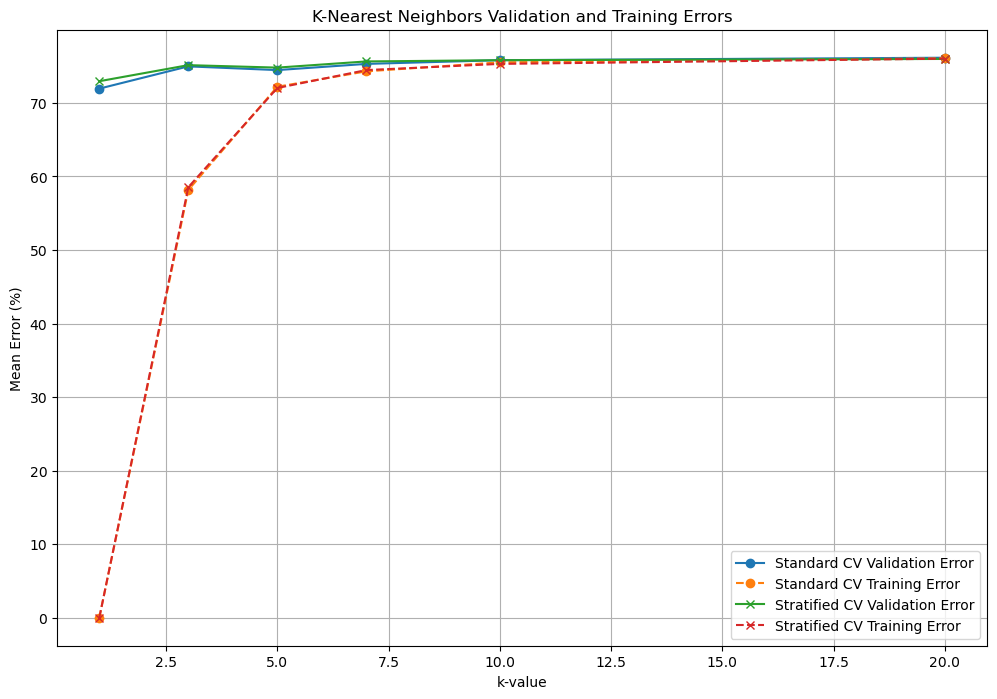

Best k for Stratified CV: 1
Error on the test dataset: 70.67%


In [8]:
def evaluate_knn_with_cross_validation(data, labels, k_values, cv_method):
    """
    Evaluate the performance of K-Nearest Neighbors (KNN) algorithm with cross-validation.

    Parameters:
    - data (array-like): The input data.
    - labels (array-like): The target labels.
    - k_values (list): List of K values to evaluate.
    - cv_method (cross-validation method): The cross-validation method to use.

    Returns:
    - mean_errors_validation (list): List of mean validation errors for each K value.
    - mean_errors_training (list): List of mean training errors for each K value.
    """
    mean_errors_validation, mean_errors_training = [], []
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_validate(
            knn, data, labels, cv=cv_method, scoring="accuracy", return_train_score=True
        )
        mean_errors_validation.append(1 - np.mean(scores["test_score"]))
        mean_errors_training.append(1 - np.mean(scores["train_score"]))
    return mean_errors_validation, mean_errors_training


def test_knn(train_data, train_labels, test_data, test_labels, best_k):
    """
    Test the performance of KNN classifier on the test dataset.

    Parameters:
    train_data (array-like): Training data.
    train_labels (array-like): Labels for the training data.
    test_data (array-like): Test data.
    test_labels (array-like): Labels for the test data.
    best_k (int): The best value of k for KNN classifier.

    Returns:
    None
    """
    # Train KNN with best k and predict on test set
    knn = KNeighborsClassifier(n_neighbors=best_k).fit(train_data, train_labels)
    test_predictions = knn.predict(test_data)

    # Calculate and display test error
    test_error = 1 - accuracy_score(test_labels, test_predictions)
    print(f"Error on the test dataset: {test_error * 100:.2f}%")


k_values = [1, 3, 5, 7, 10, 20]
standard_cv_errors = evaluate_knn_with_cross_validation(
    standardized_train_data, train_labels, k_values, 5
)
stratified_cv_errors = evaluate_knn_with_cross_validation(
    standardized_train_data,
    train_labels,
    k_values,
    StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
)

# Plotting all curves in one plot
plt.figure(figsize=(12, 8))
plt.plot(
    k_values,
    [error * 100 for error in standard_cv_errors[0]],
    label="Standard CV Validation Error",
    marker="o",
)
plt.plot(
    k_values,
    [error * 100 for error in standard_cv_errors[1]],
    label="Standard CV Training Error",
    marker="o",
    linestyle="--",
)
plt.plot(
    k_values,
    [error * 100 for error in stratified_cv_errors[0]],
    label="Stratified CV Validation Error",
    marker="x",
)
plt.plot(
    k_values,
    [error * 100 for error in stratified_cv_errors[1]],
    label="Stratified CV Training Error",
    marker="x",
    linestyle="--",
)
plt.xlabel("k-value")
plt.ylabel("Mean Error (%)")
plt.title("K-Nearest Neighbors Validation and Training Errors")
plt.legend()
plt.grid(True)
plt.show()

# Identifying the best k from stratified CV validation error
best_k = k_values[np.argmin(stratified_cv_errors[0])]
print(f"Best k for Stratified CV: {best_k}")


test_knn(
    standardized_train_data, train_labels, standardized_test_data, test_labels, best_k
)

- The graph plotted shows four curves representing mean validation and training errors for both cross-validation methods. The lowest mean errors for each curve are:
  - **Standard CV Validation Error:** k = 7
  - **Standard CV Training Error:** k = 1
  - **Stratified CV Validation Error:** k = 1
  - **Stratified CV Training Error:** k = 1
  
- Regarding model complexity, lower values of k result in a more complex model, leading to overfitting, as indicated by the low training error at k = 1. As k increases, the model becomes simpler, potentially leading to underfitting, which is not observed within the provided range of k.

- The k value with the lowest mean validation error from the stratified 5-fold cross-validation is k = 1. The error on the test dataset using this k value is 70.67%.


## 7. Performance Comparison

Perform stratified 5-fold cross-validation on the 4-class classification problem
using the three classification methods assigned to you:

```python
"Decision Tree": DecisionTreeClassifier(max_depth=10),
"Neural Network": MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
"Random Forest": RandomForestClassifier(),
```

Use these models and plot the (3) confusion matrices for using three approaches
(clearly label the classes) on the test set. (If you use code from any website,
please do proper referencing. You will get 0 point for this assignment without
proper referencing) (3.75 points)

- By visually comparing (e.g., looking at the color on the diagonal values,
  etc.) the three confusion matrices (on the test set), which do you think is
  the best method? Why? (0.50 point)

- Based on the mean validation accuracies (from the 5-fold cross-validation) for
  the three methods. Which is the best method? (0.25 point)

- Compute the accuracies for the three methods on the test set. Which is the
  best method? (0.25 point)

- Compute the F-measure for the three methods on the test set. Which is the best
  method? (0.25 point)


Descision Tree - Mean Validation Accuracy: 0.3277
Neural Network - Mean Validation Accuracy: 0.3143
Random Forest - Mean Validation Accuracy: 0.4134
Descision Tree - Test Accuracy: 0.2400
Descision Tree - F-Measure: 0.2365
Neural Network - Test Accuracy: 0.2533
Neural Network - F-Measure: 0.2484
Random Forest - Test Accuracy: 0.4067
Random Forest - F-Measure: 0.3795


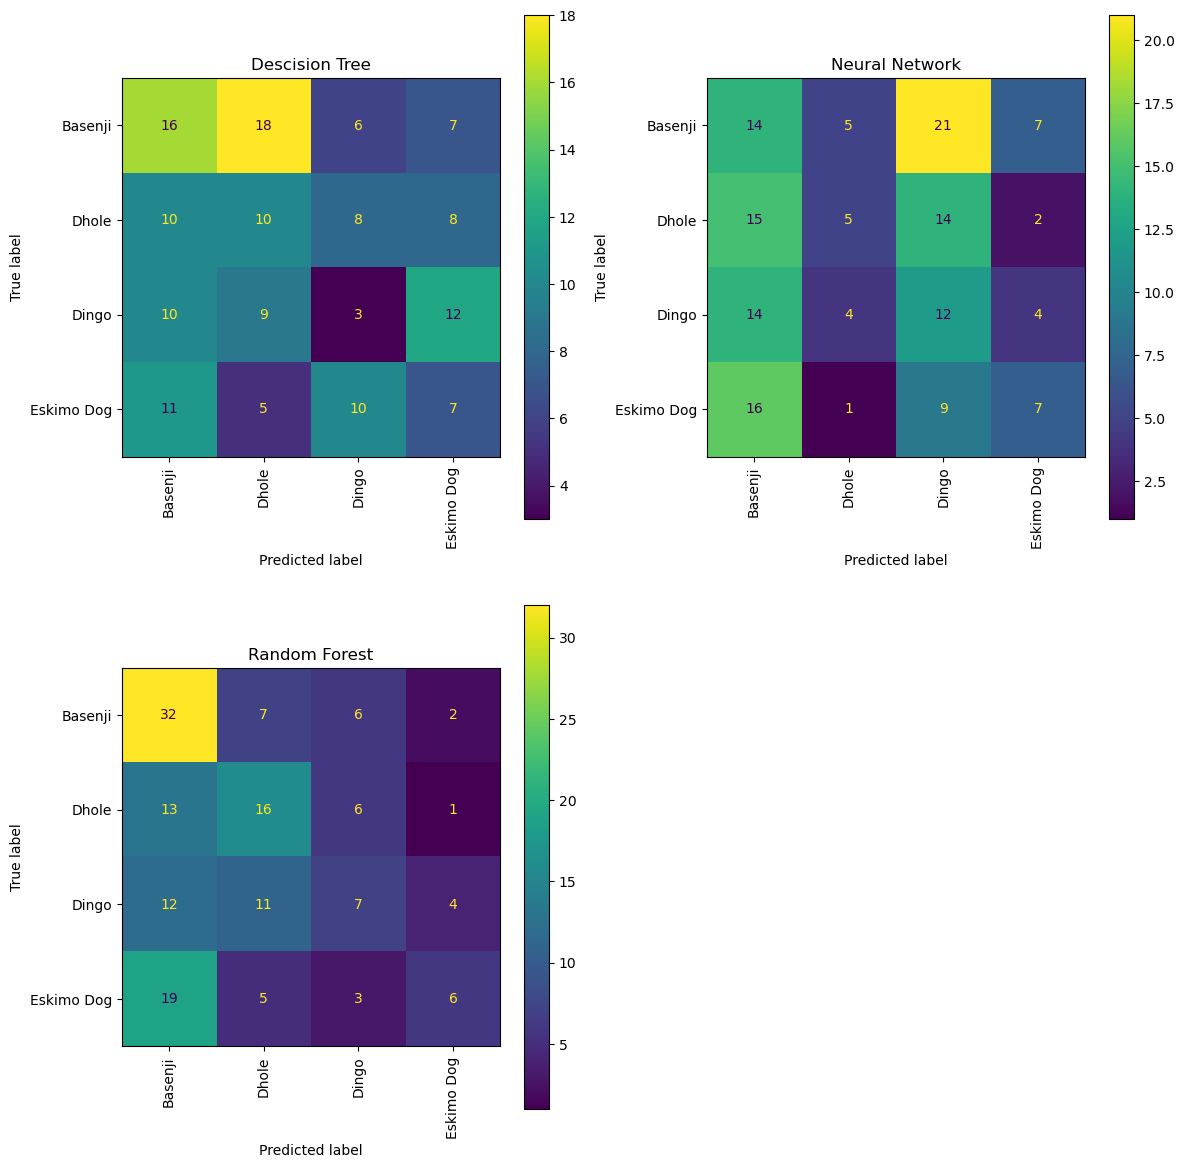

In [9]:
def encode_labels(label_mapping, *label_lists):
    """
    Encodes the labels using the provided label mapping.

    Parameters:
    - label_mapping (dict): A dictionary mapping original labels to encoded labels.
    - *label_lists (list): Variable number of lists containing the original labels.

    Returns:
    - encoder (LabelEncoder): The fitted LabelEncoder object.
    - *encoded_lists (list): Variable number of lists containing the encoded labels.
    """
    encoder = LabelEncoder()
    encoded_lists = []
    for labels in label_lists:
        proper_labels = [label_mapping[breed] for breed in labels]
        encoded_lists.append(
            encoder.fit_transform(proper_labels)
            if encoded_lists == []
            else encoder.transform(proper_labels)
        )
    return encoder, *encoded_lists


def evaluate_models(models, data, labels, cv_method):
    """
    Evaluate the performance of different models using cross-validation.

    Parameters:
    - models (dict): A dictionary containing the models to be evaluated.
    - data (array-like): The input data.
    - labels (array-like): The target labels.
    - cv_method: The cross-validation method to be used.

    Returns:
    - mean_validation_accuracies (dict): A dictionary containing the mean validation accuracies for each model.
    """
    mean_validation_accuracies = {}
    for name, model in models.items():
        cv_scores = cross_val_score(
            model, data, labels, cv=cv_method, scoring="accuracy"
        )
        mean_validation_accuracies[name] = np.mean(cv_scores)
        print(
            f"{name} - Mean Validation Accuracy: {mean_validation_accuracies[name]:.4f}"
        )
    return mean_validation_accuracies


def fit_predict_evaluate(models, train_data, train_labels, test_data, test_labels):
    """
    Fits the given models on the training data, predicts labels for the test data,
    and evaluates the performance of each model using confusion matrices, test accuracies,
    and F-measures.

    Parameters:
    - models (dict): A dictionary containing the models to be evaluated, where the keys are
                     the names of the models and the values are the model objects.
    - train_data (array-like): The training data.
    - train_labels (array-like): The labels corresponding to the training data.
    - test_data (array-like): The test data.
    - test_labels (array-like): The labels corresponding to the test data.

    Returns:
    - confusion_matrices (dict): A dictionary containing the confusion matrices for each model.
    - test_accuracies (dict): A dictionary containing the test accuracies for each model.
    - f_measures (dict): A dictionary containing the F-measures for each model.
    """
    confusion_matrices, test_accuracies, f_measures = {}, {}, {}
    for name, model in models.items():
        model.fit(train_data, train_labels)
        predictions = model.predict(test_data)
        confusion_matrices[name] = confusion_matrix(test_labels, predictions)
        test_accuracies[name] = accuracy_score(test_labels, predictions)
        f_measures[name] = f1_score(test_labels, predictions, average="weighted")
        print(f"{name} - Test Accuracy: {test_accuracies[name]:.4f}")
        print(f"{name} - F-Measure: {f_measures[name]:.4f}")
    return confusion_matrices, test_accuracies, f_measures


def plot_confusion_matrix(cm, classes, title="Confusion matrix", cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix with numbers inside the cells.

    Parameters:
    - cm (numpy.ndarray): The confusion matrix.
    - classes (list): The list of class labels.
    - title (str): The title of the plot (default: "Confusion matrix").
    - cmap (matplotlib colormap): The colormap for the plot (default: plt.cm.Blues).

    Returns:
    None
    """
    plt.imshow(cm, interpolation="nearest", cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.0
    for i, j in np.ndindex(cm.shape):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")


def plot_confusion_matrices(confusion_matrices, class_names):
    """
    Plots the confusion matrices for each class in a grid layout.

    Parameters:
    - confusion_matrices (dict): A dictionary containing the confusion matrices for each class.
    - class_names (list): A list of class names.

    Returns:
    None
    """

    fig, axs = plt.subplots(2, 2, figsize=(12, 12))
    axs = axs.flatten()

    fig.delaxes(axs[-1])

    for ax, (name, cm) in zip(axs, confusion_matrices.items()):
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        disp.plot(ax=ax, xticks_rotation="vertical")
        ax.set_title(name)

    # Center the last plot
    axs[-1].set_position([0.5, 0.5, 0.5, 0.5])

    plt.tight_layout()
    plt.show()


encoder, train_labels_encoded, test_labels_encoded = encode_labels(
    breed_mapping, train_labels, test_labels
)


models = {
    "Descision Tree": DecisionTreeClassifier(max_depth=10),
    "Neural Network": MLPClassifier(hidden_layer_sizes=(10, 10, 10)),
    "Random Forest": RandomForestClassifier(),
}


stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
evaluate_models(models, standardized_train_data, train_labels_encoded, stratified_cv)


confusion_matrices, test_accuracies, f_measures = fit_predict_evaluate(
    models,
    standardized_train_data,
    train_labels_encoded,
    standardized_test_data,
    test_labels_encoded,
)

# Plot confusion matrices
class_names = encoder.classes_
plot_confusion_matrices(confusion_matrices, class_names)

#### Confusion Matrices Analysis
- **Decision Tree:** 
  - True Positives for classes (Basenji, Dhole, Dingo, Eskimo Dog): 16, 10, 9, 10
  - Mean Validation Accuracy: 0.3277
  - Test Accuracy: 0.2400
  - F-Measure: 0.2365

- **Neural Network:** 
  - True Positives for classes (Basenji, Dhole, Dingo, Eskimo Dog): 14, 15, 14, 16
  - Mean Validation Accuracy: 0.3143
  - Test Accuracy: 0.2533
  - F-Measure: 0.2484

- **Random Forest:** 
  - True Positives for classes (Basenji, Dhole, Dingo, Eskimo Dog): 32, 16, 11, 19
  - Mean Validation Accuracy: 0.4134
  - Test Accuracy: 0.4067
  - F-Measure: 0.3795

### Visually Best Method
- **Random Forest** appears to be the best method as it has the highest number of true positives and the most saturated diagonal, indicating the highest number of correct classifications for each class.

### Statistically Best Method
- **Based on Mean Validation Accuracy:** Random Forest (0.4134)
- **Based on Test Accuracy:** Random Forest (0.4067)
- **Based on F-Measure:** Random Forest (0.3795)

The Random Forest classifier not only shows the best visual representation in the confusion matrix but also backs it up statistically with the highest mean validation accuracy, test accuracy, and F-measure.

**References:**

1. [Machine Learning Classification Topics on Github](https://github.com/topics/machine-learning-classification)
2. [Comparative Analysis of Different Classification Algorithms by Tanmay Jay](https://github.com/tanmayjay/Comparative-Analysis-of-Different-Classification-Algorithms)
3. [Binary Classifier Comparison on Github](https://github.com/cstub/ml-ids/blob/master/notebooks/07_binary_classifier_comparison/binary-classifier-comparison.ipynb)
4. [Classification And Comparison Via Neural Networks by Neu Spiral on Github](https://github.com/neu-spiral/ClassificationAndComparisonViaNeuralNetworks)